<a href="https://colab.research.google.com/github/HARJAP-SINGH-3105/Options-Pricing-and-Valuations/blob/main/Brownian%20and%20Monte%20Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yahoo_fin
!pip install opstrat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 6.8 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 106 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 29.0 MB/s 
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=74b7d9d6f0a5c65d11aa333e52ee9abd9a5937e971d078ce933018177d675999
  Stored in directory: /root/.cache/pip/wheels/e5/33/1f/68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=64da74bcaba24ae4f3de6e41c72796cdabed7fa4d72496563f0f18680f2ee618
  Stored in directory: /root/.cache/pip/wheels/83/63/2f/117884c3b19d46b64d3d61690333aa80c88dc14050e269c546
Successfully built parse sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from yahoo_fin.stock_info import *
from yahoo_fin.options import *

In [4]:
import random
import math
import opstrat as op

#### Making the dataframe of options as done in asssignment 1 having expiry date on February 17th

In [5]:
sp_stocks = tickers_sp500()
# # yahoo_fin has trouble pulling info for tickers with a hyphen in their name. So lets remove that.......
for item in sp_stocks:
  if(len(item.split('-'))>1):
    sp_stocks.remove(item)
print('The number of stocks: {}'.format(len(sp_stocks)))
# Let’s go for February 17th (any of the dates will do)
expiry_date = get_expiration_dates(sp_stocks[0])[1]
data = pd.DataFrame()

for item in sp_stocks:
  try:
    price = get_live_price(item)
    option = get_calls(item ,expiry_date)
    option['CurrentPrice'] = price
    option['Ticker'] = item
    option['DateExp'] =expiry_date
    data = data.append(option)
  
  except:
    pass


The number of stocks: 501


In [6]:
data.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,CurrentPrice,Ticker,DateExp
0,A230217C00090000,2022-09-23 2:50PM EST,90.0,36.00,41.4,43.6,0.0,-,1,1,0.00%,148.089996,A,"February 17, 2023"
1,A230217C00100000,2022-08-17 1:34PM EST,100.0,46.60,32.9,34.2,0.0,-,7,3,0.00%,148.089996,A,"February 17, 2023"
2,A230217C00110000,2022-12-05 11:25AM EST,110.0,44.53,0.0,0.0,0.0,-,1,1,0.00%,148.089996,A,"February 17, 2023"
3,A230217C00120000,2022-08-09 11:23AM EST,120.0,18.80,20.7,21.3,0.0,-,1,1,0.00%,148.089996,A,"February 17, 2023"
4,A230217C00125000,2022-11-10 2:25PM EST,125.0,24.85,29.5,31.4,0.0,-,2,57,80.95%,148.089996,A,"February 17, 2023"


#### Let's find the price of stocks using the below differential Equation:
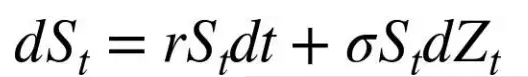
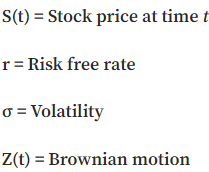

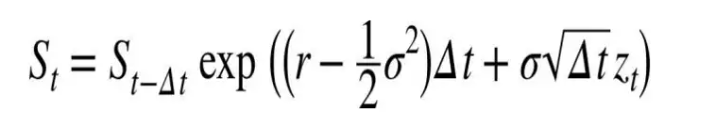

In [7]:
# Calculating total time (in days):
from datetime import date
from datetime import datetime
timedate_until_exp = datetime.strptime(expiry_date, '%B %d, %Y') - datetime.today()
days_remaining = int(timedate_until_exp.days)
days_remaining

49

In [8]:
def brownian_motion(row,T,sample,r):

  sigma = float(row['Implied Volatility'].split('%')[0])/100.0
  dt =1.0/365.0 #-----------------------------
  all_results =[]
  for i in range(sample):
    day_prices= []
    price = row['CurrentPrice']
    day_prices.append(price)
    for k in range(T):
      price1 = price*float((np.exp((r-(sigma**2.0)*0.5)*dt + sigma*(dt**0.5)*np.random.standard_normal(1))))
      day_prices.append(price1)
      price =price1
    all_results.append(day_prices)
  return all_results

In [9]:
def visualize(T,results,Ticker):
  x_axis= np.arange(0,T+1,1)
  fig = plt.figure(figsize=(10,10))
  for i,list in enumerate(results):
    plt.plot(x_axis,list)
    if(i>100):
      break 


  plt.xlabel('Steps')
  plt.ylabel('Prices')
  plt.title('100 Brownian Motion path of {}'.format(Ticker))
  plt.show()

### Evaluating option price using Monte Carlo

In [10]:
def Monte_Carlo(results,strike,T,r):
  sum=0
  for item in results:
    sum += max(item[-1]-strike,0)
    
  option_price = np.exp(-r*T/365.0)*(sum/len(results))
  return option_price 
  


In [11]:
def final_ans(row,r,sigma,days_remaining,results,samples):
  ticker = row['Ticker']
  bsm = op.black_scholes(K=row['Strike'],St=row['CurrentPrice'],r=r*100,v =sigma,t=days_remaining,type='c')
  bsm_price = bsm['value']['option value']
  print('The present value of option of {} as per Black and Scholes Model comes out to be:{}'.format(ticker,bsm_price))
  monte_price =Monte_Carlo(results,row['Strike'],days_remaining,r)
  print('The present value of option of {} as per Monte Carlo method with {} simulations comes out to be:{}'.format(ticker,samples,monte_price))

#### let's apply for 'KEYS' stock now:

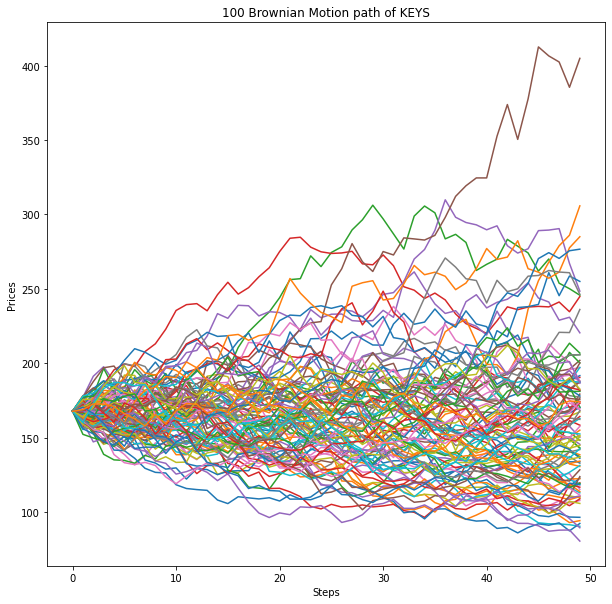

In [12]:
row = data[data['Ticker']=='KEYS'].iloc[0]
strike = row['Strike']
ticker = row['Ticker']
samples=20000
r =0.0475 # here we taken risk-free rate of 1-year treasury bills.---------------
sigma = float(row['Implied Volatility'].split('%')[0])
results =brownian_motion(row,days_remaining,samples,r)
visualize(days_remaining,results,ticker)

In [13]:
row

Contract Name           KEYS230217C00155000
Last Trade Date       2022-08-11 8:30AM EST
Strike                                155.0
Last Price                             23.8
Bid                                    23.4
Ask                                    25.3
Change                                  7.5
% Change                            +46.01%
Volume                                    2
Open Interest                            12
Implied Volatility                   72.11%
CurrentPrice                     167.660004
Ticker                                 KEYS
DateExp                   February 17, 2023
Name: 0, dtype: object

In [14]:
final_ans(row,r,sigma,days_remaining,results,samples)

The present value of option of KEYS as per Black and Scholes Model comes out to be:24.585762657878675
The present value of option of KEYS as per Monte Carlo method with 20000 simulations comes out to be:24.407203039463052


#### let's apply for 'ZBRA'

```
# This is formatted as code
```

' stock now:

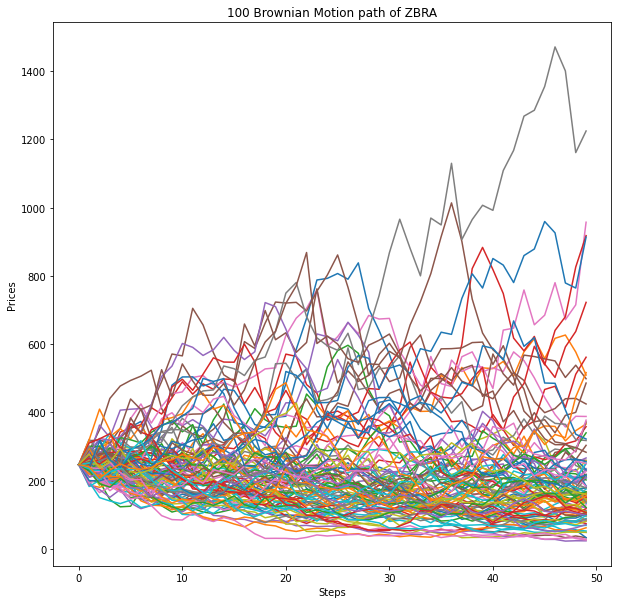

In [23]:
row = data[data['Ticker']=='ZBRA'].iloc[0]
strike = row['Strike']
ticker = row['Ticker']
samples=20000
r =0.0475 # here we taken risk-free rate as average of treasury bills.---------------
sigma = float(row['Implied Volatility'].split('%')[0])
results =brownian_motion(row,days_remaining,samples,r)
visualize(days_remaining,results,ticker)

In [24]:
row

Contract Name            ZBRA230217C00290000
Last Trade Date       2022-08-02 12:22PM EST
Strike                                 290.0
Last Price                              66.0
Bid                                     66.7
Ask                                     68.4
Change                                   0.0
% Change                                   -
Volume                                     2
Open Interest                              1
Implied Volatility                   225.41%
CurrentPrice                      246.839996
Ticker                                  ZBRA
DateExp                    February 17, 2023
Name: 0, dtype: object

In [25]:
final_ans(row,r,sigma,days_remaining,results,samples)

The present value of option of ZBRA as per Black and Scholes Model comes out to be:66.44937853793036
The present value of option of ZBRA as per Monte Carlo method with 20000 simulations comes out to be:66.35351772357231
